In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision import models,datasets
import matplotlib.pyplot as plt
torch.__version__

'2.2.1'

# 4.2.3 可视化理解卷积神经网络
在上一节中我们已经通过一个预训练的VGG16模型对一张图片进行了分类，下面我们粘贴上一节的代码

In [2]:
cat_img=Image.open('./1280px-Felis_silvestris_catus_lying_on_rice_straw.jpg')
transform_224= transforms.Compose([
    transforms.Resize(224), 
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
])


cat_img_224=transform_224(cat_img)

上面的代码是我们读取了一张图片，并对图片进行了一些预处理，下面我们来创建vgg16的预训练好网络模型

In [3]:
net = models.vgg16(pretrained=True)# 修改这里可以更换其他与训练的模型
inputs=cat_img_224[np.newaxis] #这两个方法都可以cat_img_224[None,::]

/root/miniconda3/envs/paddle_learn/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/paddle_learn/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:44<00:00, 12.5MB/s] 


进行一次前向的传播，看看得到了什么结果

In [5]:
out = net(inputs)
_, preds = torch.max(out.data, 1)
preds
label=preds.numpy()[0]
label

282

我们看到了，这里返回的是285，代码几乎一样，但是返回的结果与上一节的样例有差别，这是什么原因呢？
首先我们先看一下这个数字的含义，我们使用的是通过imagenet来作为预训练的模型，imagenet里面有1000个分类，我们如何去找这个含义呢？
有好心人已经给我们准备好了 [这个连接](https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/c2c91c8e767d04621020c30ed31192724b863041/imagenet1000_clsid_to_human.txt)
我们找一下 285: 'Egyptian cat', 说明识别出了是一只猫，种类还是埃及猫，应该还是比较准确的，但是这张图片是我特意寻找的，里面包含了很多隐藏的细节，这里就不多介绍了，大家如果有兴趣，可以换一个模型，或者修改下transforms方法，看看模型都会识别出来是什么类别。

注：不同的预训练权重也会出现不同的结果，我测试出现过277，282，287等结果

下面我们开始进入正题，卷积神经网络的可视化

## 背景
CNN模型虽然在图像处理上表现出非常良好的性能和准确性，但一直以来都被认为是一个黑盒模型，人们无法了解里面的工作机制。
针对这个问题，研究人员除了从理论层面去寻找解释外，也提出了一些可视化的方法直观地理解CNN的内部机理，毕竟眼见为实，看到了大家就相信了。
这里介绍两类方法，一种是基于Deconvolution, 另一种则是基于反向传播的方法。我们主要使用代码实现基于反向传播的方法的可视化。

## 基于Deconvolution的方法 
[Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901) 
主要是将激活函数的特征映射回像素空间，来揭示什么样的输入模式能够产生特定的输出,因为网络是有层级关系的，所以越靠近输出的层级学到的特征越抽象，与实际任务越相关，这里就不多介绍了，[这里](https://github.com/saketd403/Visualizing-and-Understanding-Convolutional-neural-networks)有一个使用 keras的实现，有兴趣的可以看看

# 基于Backpropagation的方法 
另外一类的实现就是基于Backpropagation的方法，这里我们主要进行介绍，在介绍之前，我们首先要引用一下别人写的代码
[pytorch-cnn-visualizations ](https://github.com/utkuozbulak/pytorch-cnn-visualizations),将这个代码的src目录放到与这个notebook同级别目录下，我们后面会直接调用他的代码进行演示操作。

首先，我们做一些准备工作

In [6]:
import sys
sys.path.insert(0, './pytorch-cnn-visualizations/src/')
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
def rescale_grads(map,gradtype="all"):
    if(gradtype=="pos"):    
        map = (np.maximum(0, map) / map.max())
    elif gradtype=="neg":
        map = (np.maximum(0, -map) / -map.min())
    else:
        map = map - map.min()
        map /= map.max()
    return map

### Guided-Backpropagation 
这个方法来自于ICLR-2015 的文章[《Striving for Simplicity: The All Convolutional Net》](https://arxiv.org/abs/1412.6806)，文中提出了使用stride convolution 替代pooling 操作，这样整个结构都只有卷积操作。作者为了研究这种结构的有效性，提出了guided-backpropagation的方法。

大致的方法为：选择某一种输出模式，然后通过反向传播计算输出对输入的梯度。这种方式与上一种deconvnet的方式的唯一区别在于对ReLU梯度的处理。

ReLU在反向传播的计算采用的前向传播的特征作为门阀，而deconvnet采用的是梯度值，guided-backpropagation则将两者组合在一起使用，这样有助于得到的重构都是正数。

这段话可能有点绕，具体细节还是看论文吧,我们这里只关注如何实现

In [7]:
inputs.requires_grad=True # 这句话必须要有，否则会报错
from guided_backprop import GuidedBackprop #这里直接引用写好的方法，在src，目录找想对应的文件
GB=GuidedBackprop(net)
gp_grads=GB.generate_gradients(inputs, label)
gp_grads=np.moveaxis(gp_grads,0,-1)
#我们分别计算三类的gp
ag=rescale_grads(gp_grads,gradtype="all")
pg=rescale_grads(gp_grads,gradtype="pos")
ng=rescale_grads(gp_grads,gradtype="neg")

/root/miniconda3/envs/paddle_learn/lib/python3.8/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


下面我们使用matplotlib看看结果

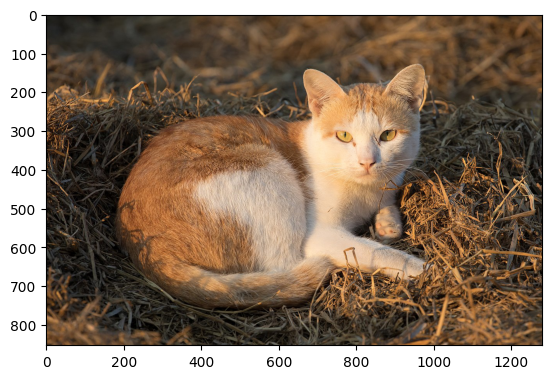

In [8]:
plt.imshow(cat_img)

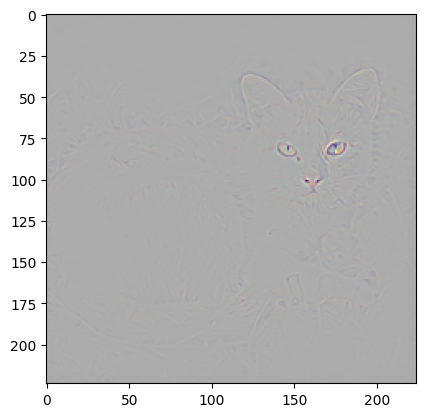

In [9]:
plt.imshow(ag)

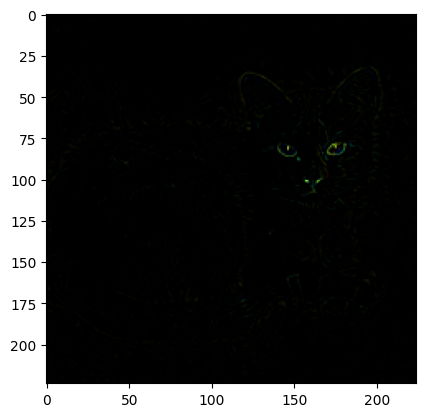

In [10]:
plt.imshow(ng)

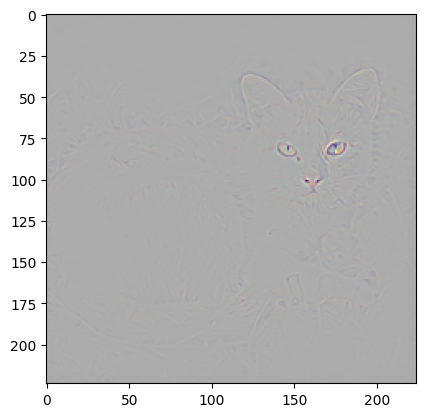

In [11]:
plt.imshow(ag)

上面三张图是rbg三个通道的展示结果，下面我们合并成一个通道再看一下

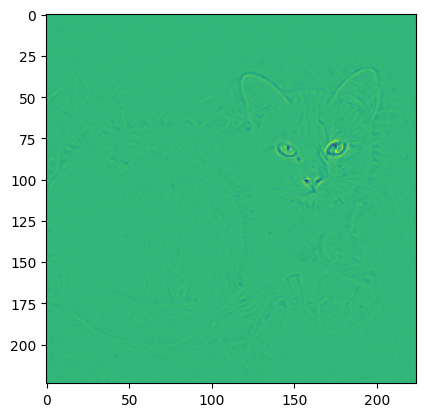

In [12]:
gag=rgb2gray(ag)
plt.imshow(gag)

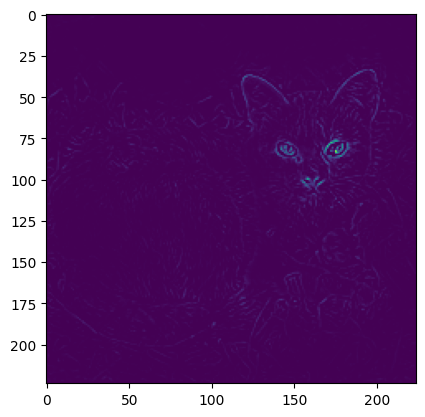

In [13]:
gpg=rgb2gray(pg)
plt.imshow(gpg)

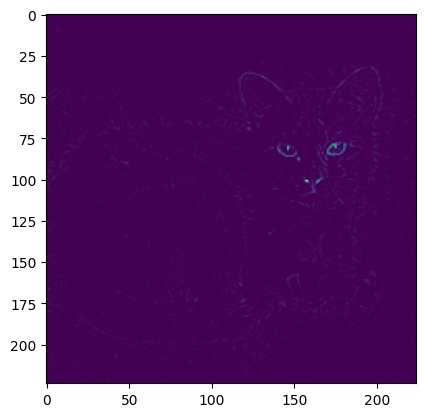

In [14]:
gng=rgb2gray(ng)
plt.imshow(gng)

### CAM（Class Activation Map） 
这个方法严格来说不是基于梯度的，但是后面我们会将反向传播与CAM整合，所以简单的对CAM做个说明。

CAM 来自CVPR 2016 [《Learning Deep Features for Discriminative Localization》](https://arxiv.org/abs/1512.04150)，作者在研究global average pooling（GAP）时，发现GAP不止作为一种正则，减轻过拟合，在稍加改进后，可以使得CNN具有定位的能力，CAM（class activation map）是指输入中的什么区域能够指示CNN进行正确的识别。

通常特征图上每个位置的值在存在其感知野里面某种模式时被激活，最后的class activation map是这些模式的线性组合，我们可以通过上采样，将class activation map 还原到与原图一样的大小，通过叠加，我们就可以知道哪些区域是与最后分类结果息息相关的部分。

这里就不介绍了

###  Grad-CAM 
[Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

顾名思义 Grad-CAM的加权系数是通过反向传播得到的，而CAM的特征加权系数是分类器的权值。

Grad-CAM 与 CAM相比，它的优点是适用的范围更广，Grad-CAM对各类结构，各种任务都可以使用。这两种方法也可以应用于进行弱监督下的目标检测，后续也有相关工作基于它们进行改进来做弱监督目标检测。 

In [16]:
import math
from gradcam import GradCam
from guided_gradcam import guided_grad_cam
from guided_backprop import GuidedBackprop
nlayers=len(net.features._modules.items())-1
print(nlayers) # 打印一下一共有多少层
cam_list=[]
#下面我们循环每一层

for layer in range(nlayers):
    #GradCam
    grad_cam = GradCam(net,target_layer=layer)
    cam = grad_cam.generate_cam(inputs, label)
    
    #GuidedBackprop
    GBP = GuidedBackprop(net)
    guided_grads = GBP.generate_gradients(inputs, label)
    
    # Guided Grad cam
    cam_gb = guided_grad_cam(cam, guided_grads)
    cam_list.append(rgb2gray(np.moveaxis(cam_gb,0,-1)))

30


我们选个图，看看效果

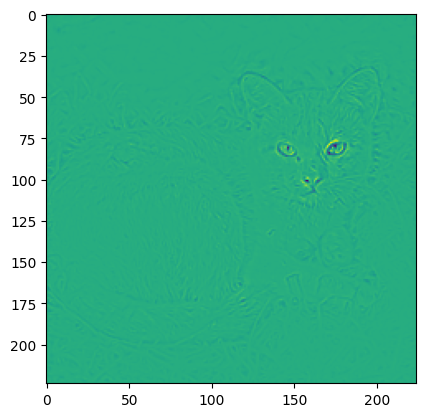

In [17]:
plt.imshow(cam_list[0])

在 Visualizing and Understanding Convolutional Networks  中作者还给出了其他不同的方法，这里就不详细说明了

需要注意的是，在使用 Visualizing and Understanding Convolutional Networks的时候，对网络模型是有要求的，要求网络将模型包含名为features的组合层，这部分是代码中写死的，所以在pytorch的内置模型中，vgg、alexnet、densenet、squeezenet是可以直接使用的，inception(googlenet)和resnet没有名为features的组合层，如果要使用的话是需要对代码进行修改的。